## 5.9 회귀 실습 - 자전거 여 수요 예측

**컬럼 소개**
- datetime : hourly date + timestamp
- season : 1=봄, 2=여름, 3=가을, 4=겨울
- holiday : 1=토,일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날
- workingday : 1=토,일요일의 주말 및 휴일이 아닌 주중, 0=주말 및 휴일
- weather:
    - 1 = 맑음, 약간 구름 낀 흐림
    - 2 = 안개, 안개+흐림
    - 3 = 가벼운 눈, 가벼운 비+천둥
    - 4 = 심한 눈/비, 천둥/번개
- temp : 온도(섭씨)
- atemp : 체감온도(섭씨)
- humidity : 상대습도
- windspeed : 풍속
- casual : 사전에 등록되지 않는 사용자가 대여한 횟수
- registered : 사전에 등록된 사용자가 대여한 횟수
- count : 대여 횟수

### 데이터 클렌징 및 가공 

In [1]:
import numpy as anp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [3]:
# 문자열을 'datetime 타입'으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년,월,일,시간 추출
bike_df['year'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년,월,일 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [4]:
drop_columns= ['datetime','casual','registered'] # casual+registered = count이므로 casual, registered 삭제(높은 상관도로 예측 저해 가능성)
bike_df.drop(drop_columns, axis=1, inplace=True)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE(Root Mean Square Log Error) 계산
# 오버플로/언더플로 오류가 발생할 수 있으므로, log1p() 이용 + mean_squared_log_error() 이용 x
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred) # log1p() = 1+log()
    squared_error = (log_y-log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    
    # MSE는 사이킷런의 mean_absolute_error()로 계산
    mse_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE:{1:.3F}, MSE: {2:.3F}'.format(rmsle_val, rmse_val, mse_val))

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred) # MSE, RMSE, RMSLE를 모두 계산

RMSLE: 1.165, RMSE:140.900, MSE: 105.924


In [22]:
## 실제 값과 예측값이 어느정도 차이가 나는지

def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame의 칼럼으로 실제 대여 횟수인 count와 예측값을 서로 비교
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
    
    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5) # 가장 큰 상위 5위 오류   

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


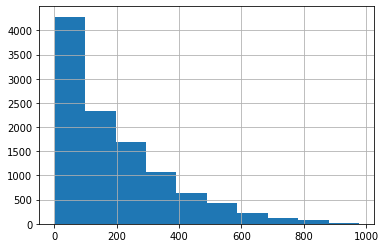

In [23]:
y_target.hist()

- Target 값이 count 값이 정규 분포가 아닌 0~200사이에 왜곡되어 있다. 이를 정규 분포 형태로 바꿔야 하는데, 가장 일반적인 방법인 로그 변환을 이용한다.  
- 변경된 Target 값을 기반으로 학습하고 예측한 값은 expml() 함수를 이용하면 원래 값으로 돌아간다.

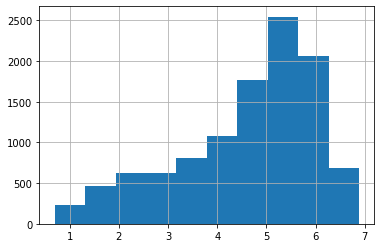

In [24]:
# log1p()를 적용한 count 값의 분포
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

- 로그로 변환한 후 완전한 정규 분포 형태는 아니짐나 변환하기 전보다는 왜곡 정도가 많이 나아졌다.

In [25]:
# Target인 count값을 log1p를 이용해 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기바으로 학습돼 예측되었기 때문에 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE:162.594, MSE: 109.286


- RMSLE 오류는 줄었지만(1.165 -> 1.017), RMSE는 오히려 더 늘었다.(140.900 -> 162.594)

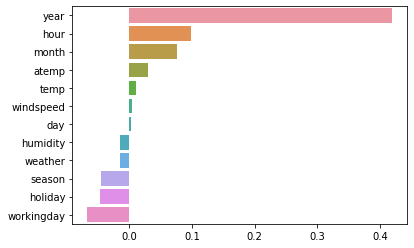

In [26]:
# 피처의 회귀 계수 값을 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- year 피처의 회귀 계수 값이 독보적으로 큰 값을 가지고 있다.  
    - year 피처는 카테고리형 피처지만, 숫자형 값으로 돼 있다.(2011,2012 <- 큰 값)  
    - 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다.  
    => 숫자형 카테고리 값을 선형 회귀에 사용할 경우, 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다.  
    => 선형 회귀에서는 이러한 피처 인코딩에 <u>원-핫 인코딩</u>을 이용해 변환해야 한다.

In [40]:
# 'year','month','hour','season','weather' 피처를 원-핫 인코딩

#X_features_ohe = pd.get_dummies(X_features, columns=['year','month','hour','holiday','workingday','season','weather']) # 결측값을 제외하고 0과 1로 구성된 더미값 생성
                                                                                                                       #  True 이면 1, False 이면 0  
    
X_features_ohe = pd.get_dummies(X_features, columns=['month','hour', 'holiday','workingday','season','weather'])    

In [43]:
X_features_ohe.head()

,temp,atemp,humidity,windspeed,year,day,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,2011,1,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,2011,1,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,2011,1,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,2011,1,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,2011,1,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [44]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    
    evaluate_regr(y_test, pred)

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.589, RMSE:97.483, MSE: 63.106
### Ridge ###
RMSLE: 0.590, RMSE:98.417, MSE: 63.651
### Lasso ###
RMSLE: 0.634, RMSE:113.031, MSE: 72.658


- 원-핫 인코딩 이후 선형 회귀의 예측 성능이 많이 향상되었다.

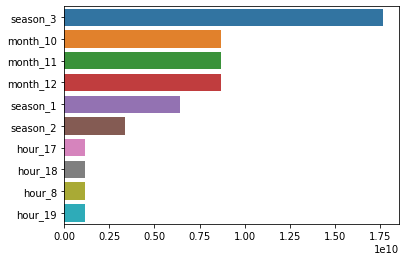

In [45]:
# 원-핫 인코딩된 데이터 세트에서 회귀계수가 높은 피처를 시각화
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

- (책이랑 다름! https://www.inflearn.com/questions/43988)
- 계절, 월, 날씨 등이 자전거를 타는데 필요한 피처의 회귀 계수가 높아졌다.

In [46]:
## 회귀 트리를 이용해 회귀 예측

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM 모델별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE:50.726, MSE: 31.413
### GradientBoostingRegressor ###
RMSLE: 0.340, RMSE:55.801, MSE: 34.340
[00:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dldms\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### XGBRegressor ###
RMSLE: 0.346, RMSE:56.474, MSE: 34.917
### LGBMRegressor ###
RMSLE: 0.316, RMSE:46.473, MSE: 28.777


- 앞선 선형 회귀 모델보다 회귀 예측 성능이 개선되었다.(데이터 세트의 유형에 따라 결과는 바뀔 수 있다.)